<img src="https://user-images.githubusercontent.com/26833433/99805971-90f66b80-2b3d-11eb-80eb-8b45a15cb68e.jpg">

## **Training and Testing YOLOv3 for Object Detection**

This notebook walks through how to train a YOLOv3 object detection model using the **TensorFlow Object Detection API**.

#YOLO (You Only Look Once)

YOLO detector is extremely fast and accurate.

YOLO apply a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.

This model looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike others systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN.

### **What's New in Version 3?**

      **YOLO v3: Better, not Faster, Stronger**

YOLOv3 uses a few tricks to improve training and increase performance, including: multi-scale predictions and a better backbone classifier. 

#### **DarkNet-53**

YOLO v3 uses a variant of Darknet, which originally has 53 layer network trained on Imagenet.

For the task of detection, 53 more layers are stacked onto it, giving us a 106 layer fully convolutional underlying architecture for YOLO v3.

![yolo](https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png)

#### **Detection at three Scales**

The newer architecture boasts of **residual skip connections**, and **upsampling**. The most salient feature of v3 is that it makes **detections at three different scales**. In YOLO v3, the detection is done by applying 1 x 1 detection kernels on feature maps of **three different sizes** at **three different places** in the network.

### **Better at detecting smaller objects**

Detections at different layers helps address the issue of detecting small objects. The upsampled layers concatenated with the previous layers help preserve the fine grained features which help in detecting small objects.

### **Choice of anchor boxes**

YOLO v3, in total uses 9 anchor boxes. Three for each scale.

![anchor](https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png)

#Setup

##### 1.  Clone and install dependencies 

In [ ]:
# Tensorflow GPU
!conda env create -f conda-gpu.yml
!conda activate yolov3-tf2-gpu

/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [ ]:
!git clone https://github.com/zzh8829/yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 433, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 433 (delta 7), reused 2 (delta 0), pack-reused 412
Receiving objects: 100% (433/433), 4.24 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (244/244), done.


In [ ]:
#Open the requirements-gpu.txt file and change the version of opencv-python to 4.1.1.26 and tensorboard to 2.1.0
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8 MB 3.7 kB/s 
     |████████████████████████████████| 28.7 MB 52 kB/s 
     |████████████████████████████████| 3.8 MB 23.7 MB/s 
     |████████████████████████████████| 448 kB 50.9 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2043997a6a136dc3e3a8c32647baf877a234d172aba284a77d8382a6c3bc76ed
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Su

##### 2.  Check Tensorflow2 version

In [ ]:
!ls

import tensorflow as tf
tf.__version__

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


'2.1.0'

##### 3.  Convert Pretrained Darknet Weight

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-10-28 11:02:18--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  58.7MB/s    in 4.2s    

2021-10-28 11:02:23 (55.8 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-10-28 11:02:24.622020: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 11:02:24.622186: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or direct

##### 4. Initialize Detector

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I1028 11:20:20.836372 140632751740800 <ipython-input-8-46e02890df13>:9] weights loaded
I1028 11:20:20.840945 140632751740800 <ipython-input-8-46e02890df13>:12] classes loaded
I1028 11:20:22.508226 140632751740800 <ipython-input-8-46e02890df13>:24] time: 1.6177759170532227
I1028 11:20:22.510089 140632751740800 <ipython-input-8-46e02890df13>:26] detections:
I1028 11:20:22.522511 140632751740800 <ipython-input-8-46e02890df13>:30] 	cup, 0.9980731010437012, [0.14266217 0.52777606 0.27184254 0.65748256]
I1028 11:20:22.528487 140632751740800 <ipython-input-8-46e02890df13>:30] 	person, 0.9976975321769714, [0.28982916 0.0985465  0.95846486 0.9202167 ]
I1028 11:20:22.533438 140632751740800 <ipython-input-8-46e02890df13>:30] 	laptop, 0.9599871039390564, [-0.01710662  0.39493686  0.5229728   0.7962776 ]
I1028 11:20:22.539640 140632751740800 <ipython-input-8-46e02890df13>:30] 	apple, 0.9081629514694214, [0.13114463 0.77143586 0.22893353 0.90729535]
I1028 11:20:22.545459 140632751740800 <ipython-inp

tf.Tensor([6], shape=(1,), dtype=int32)


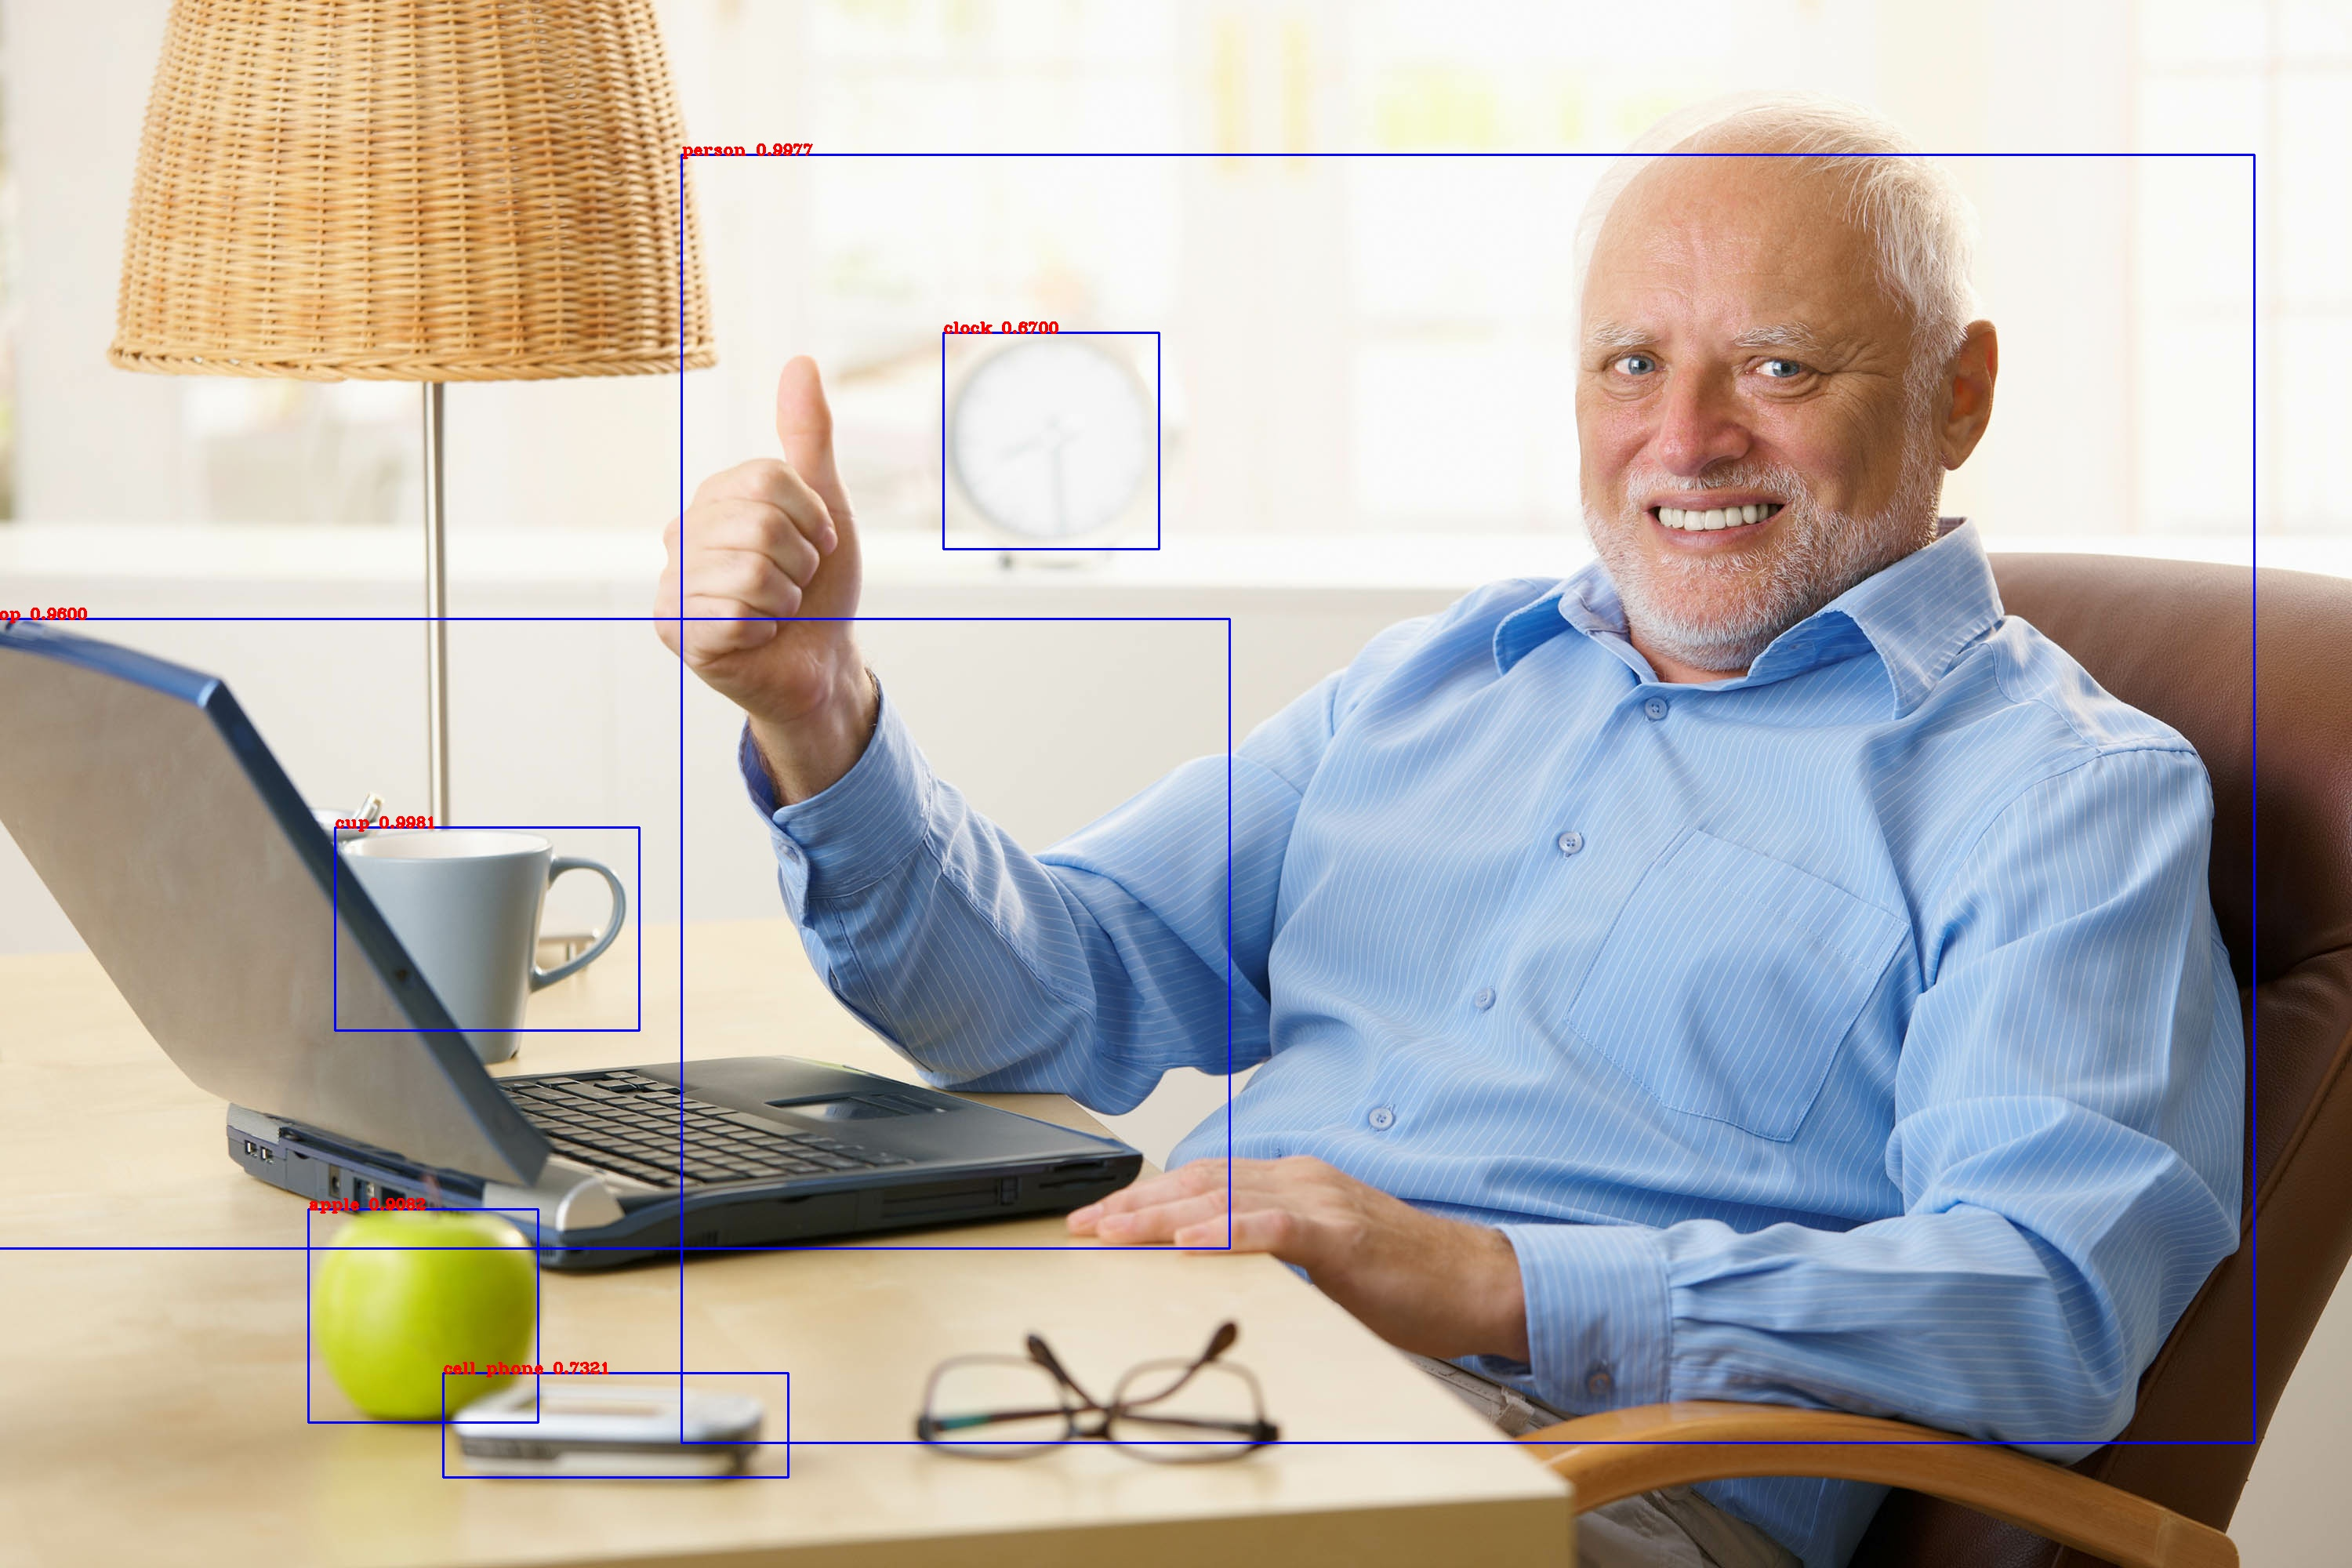

In [ ]:
FLAGS.image = 'data/meme.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

--2021-10-28 11:23:02--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘./data/voc2009_raw.tar’

./data/voc2009_raw. 100%[===================>] 892.19M  29.0MB/s    in 40s     

2021-10-28 11:23:43 (22.1 MB/s) - ‘./data/voc2009_raw.tar’ saved [935534080/935534080]



In [ ]:
!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2021-10-28 11:33:29.722700: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 11:33:29.722841: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 11:33:29.722872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I1028 11:33:30.877588 139680462858112 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 1

In [ ]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2021-10-27 15:29:54.152273: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-27 15:29:54.152437: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-27 15:29:54.152468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I1027 15:29:55.215837 139765088118656 visualize_dataset.py:22] classes loaded
2021-10-27 15:29:55.218894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library lib

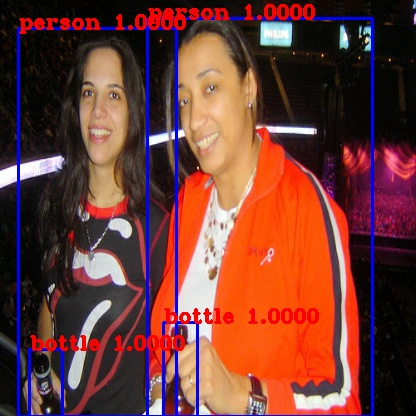

In [ ]:
from IPython.display import Image
Image(filename='./output.jpg')

In [ ]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-10-28 11:36:23.588625: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 11:36:23.588833: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 11:36:23.588864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2021-10-28 11:36:24.684258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-28 11:36:24.690304: I tensorflow/stream_executor/cuda/cuda_g

##### 6. Detect using new weights

I1028 12:00:05.229840 140632751740800 <ipython-input-13-45aae175cc4e>:16] weights loaded
I1028 12:00:05.231966 140632751740800 <ipython-input-13-45aae175cc4e>:19] classes loaded
I1028 12:00:05.573637 140632751740800 <ipython-input-13-45aae175cc4e>:30] time: 0.2924008369445801
I1028 12:00:05.575397 140632751740800 <ipython-input-13-45aae175cc4e>:32] detections:


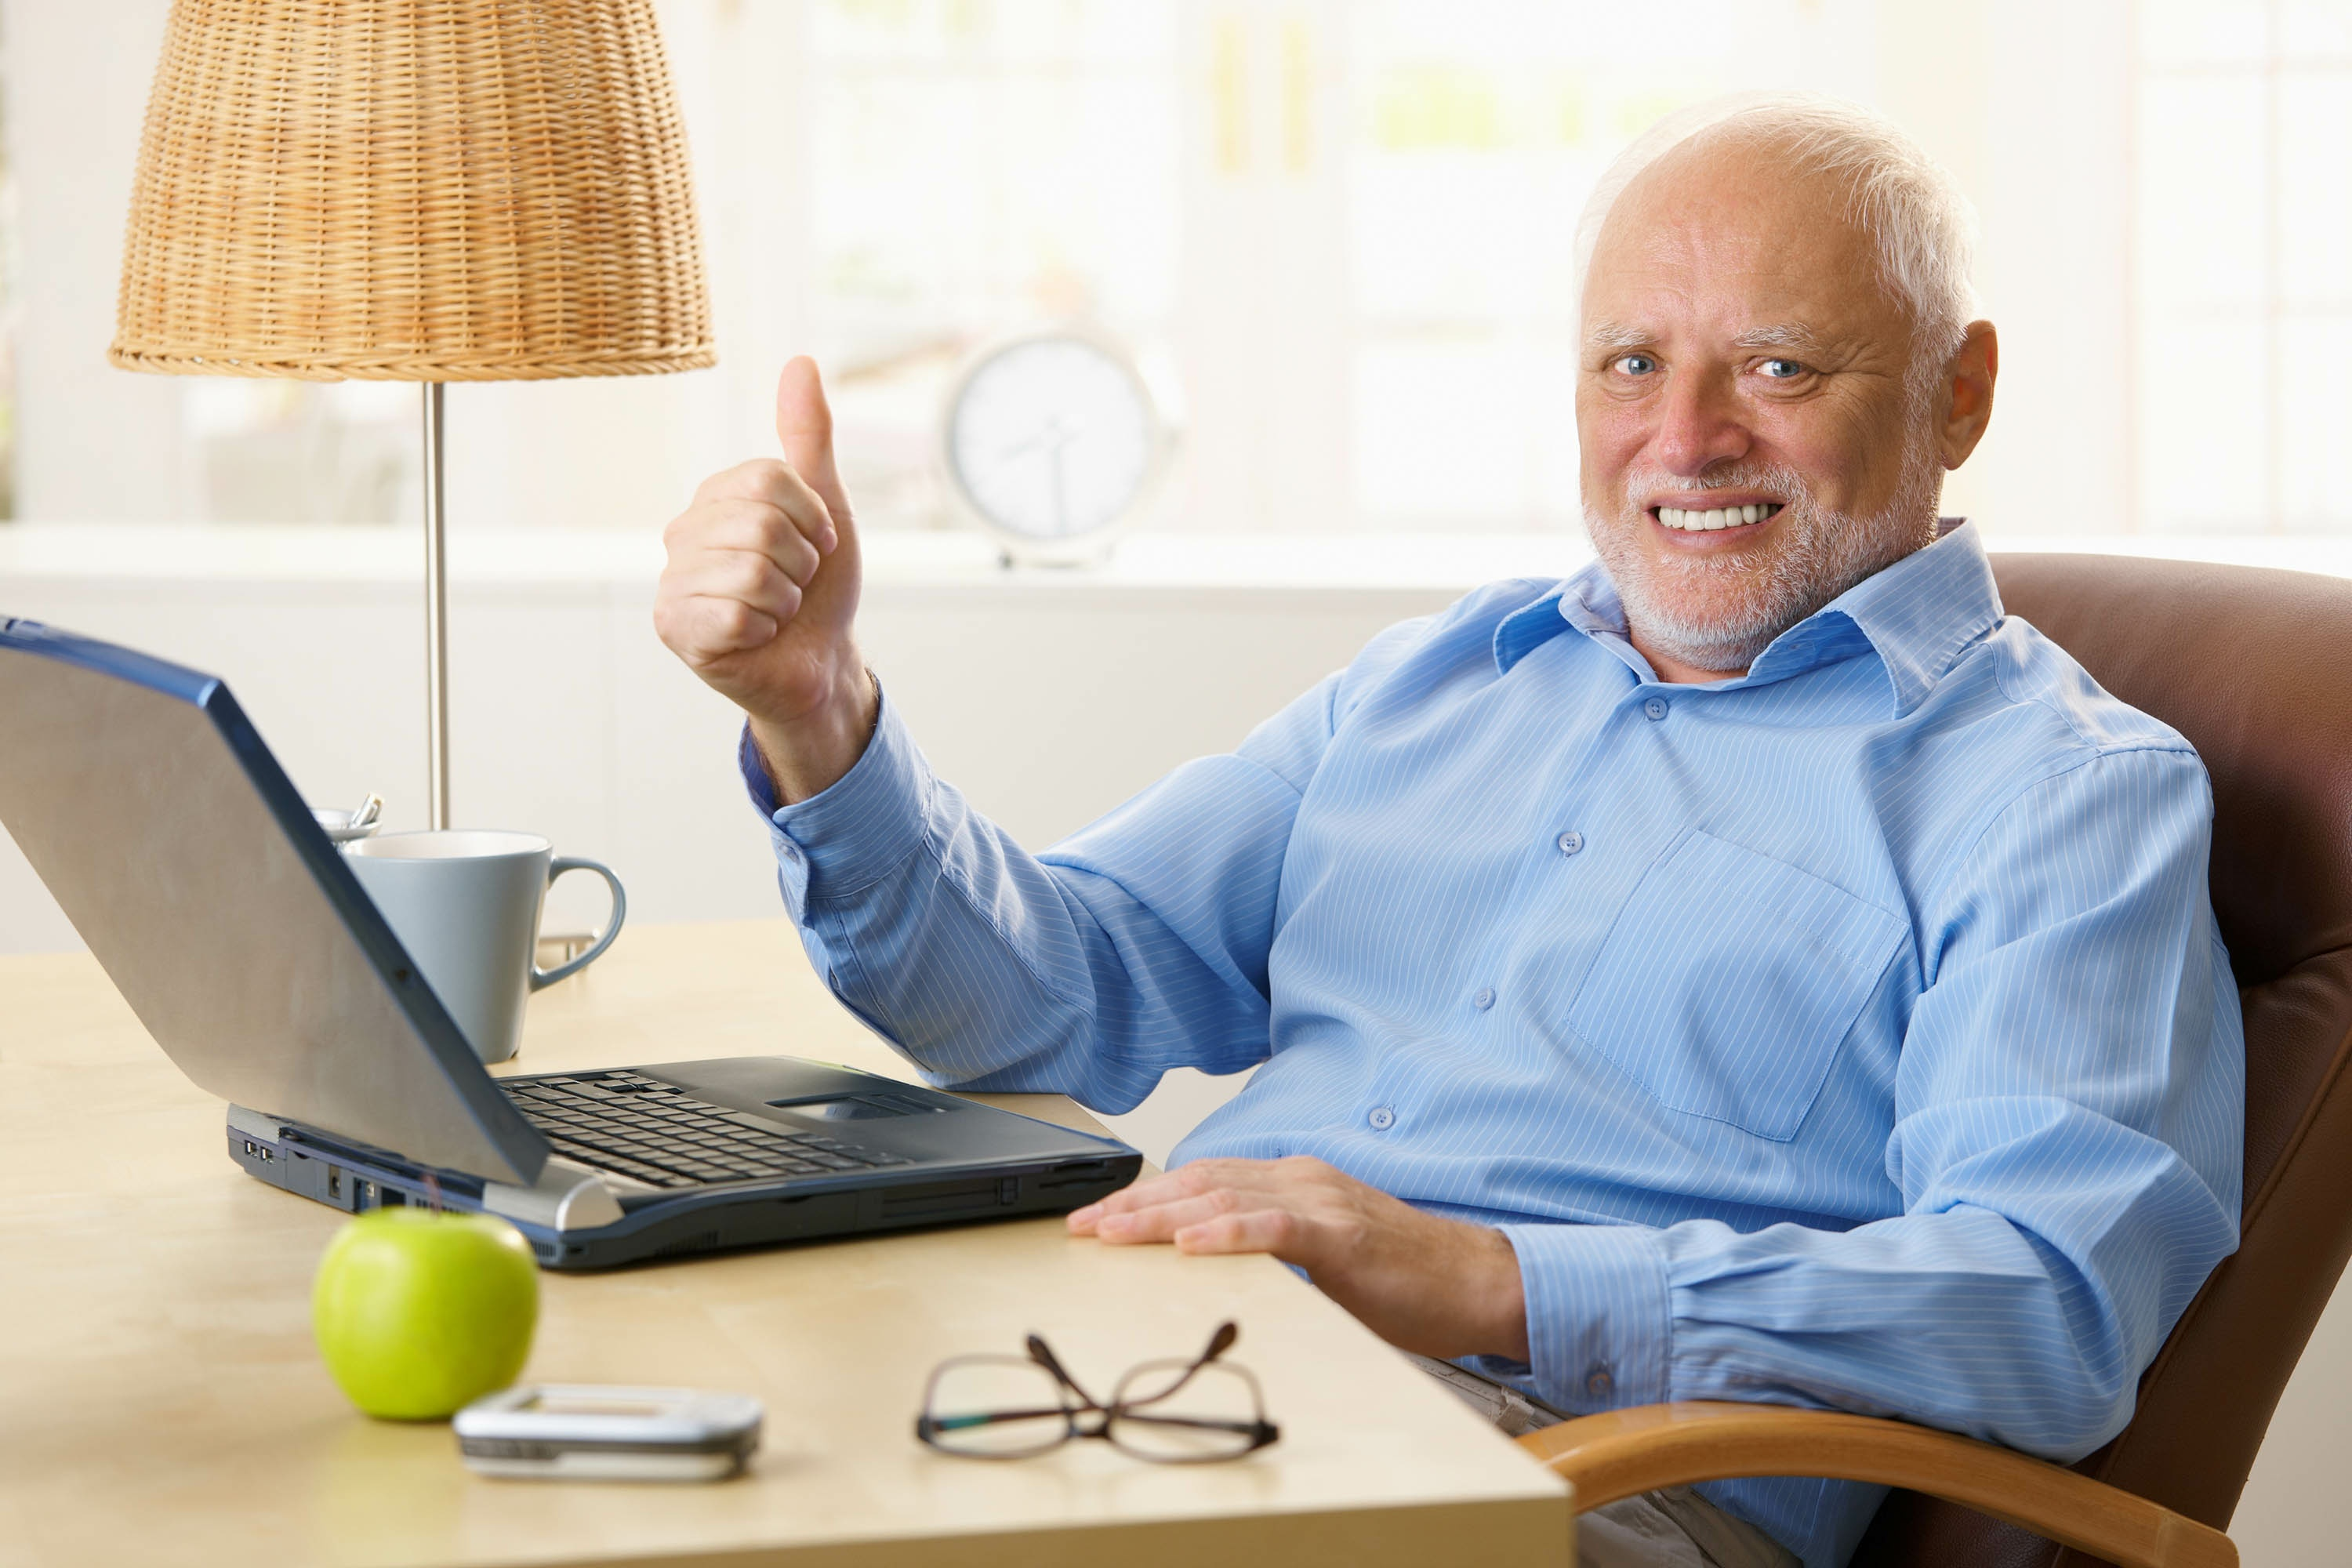

In [ ]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/meme.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

# Training using our data
In this part, we'll training an object detection model to recognize cat faces.

### Our Data

We'll be using a dataset called OxfordIIITPet (only cat part). Our dataset contains 1188 cat images and 1188 annotations (cats face).
Use Roboflow to generate **TFRecords** for each, replace their URLs in this notebook, and you're able to train on your own custom dataset.

### Prepare `tfrecord` files

In [ ]:
%cd /content/yolov3-tf2/data

/content/yolov3-tf2/data


In [ ]:
# UPDATE THIS LINK - get our data from Roboflow
!curl -L "https://app.roboflow.com/ds/efrUkfIENV?key=Dz6TFe7hUK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   2020      0 --:--:-- --:--:-- --:--:--  2015
100 27.0M  100 27.0M    0     0  35.3M      0 --:--:-- --:--:-- --:--:-- 35.3M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/face.tfrecord      
 extracting: test/face_label_map.pbtxt  
   creating: train/
 extracting: train/face.tfrecord     
 extracting: train/face_label_map.pbtxt  


###Training

In [ ]:
%cd /content/yolov3-tf2
!python train.py \
	--dataset ./data/train/face.tfrecord \
	--val_dataset ./data/test/face.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 1 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 8 \
	--weights ./checkpoints/yolov3_train_3.tf \
	--weights_num_classes 1 

/content/yolov3-tf2
2021-10-28 12:14:17.864957: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 12:14:17.865089: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-10-28 12:14:17.865117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2021-10-28 12:14:18.859386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-28 12:14:18.864798: I tensorflow/stream_

###Testing

I1028 12:32:55.740826 140632751740800 <ipython-input-23-97a0a6665ed5>:23] weights loaded
I1028 12:32:55.743239 140632751740800 <ipython-input-23-97a0a6665ed5>:26] classes loaded
I1028 12:32:56.088613 140632751740800 <ipython-input-23-97a0a6665ed5>:37] time: 0.3281216621398926
I1028 12:32:56.090450 140632751740800 <ipython-input-23-97a0a6665ed5>:39] detections:
I1028 12:32:56.101358 140632751740800 <ipython-input-23-97a0a6665ed5>:43] 	face, 0.8241079449653625, [0.32313788 0.18660404 0.49154466 0.4685896 ]


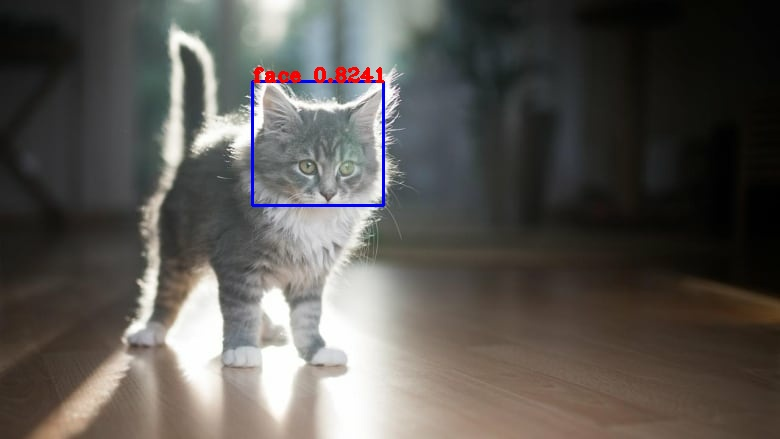

In [ ]:
import os
import glob

sample_img = 'https://i.cbc.ca/1.5256404.1566499707!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/cat-behaviour.jpg'
import urllib.request
urllib.request.urlretrieve(sample_img, "data/ca.jpg")

FLAGS.num_classes = 1
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_8.tf'
FLAGS.image = 'data/ca.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))